In [136]:
from sklearn.base import BaseEstimator
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import pandas as pd
from catboost import CatBoost, CatBoostClassifier
from problem import get_test_data, get_train_data
from sklearn.metrics import log_loss

In [5]:


def compute_rolling_std(X_df, feature, time_window, center=True):
    """
    For a given dataframe, compute the standard deviation over
    a defined period of time (time_window) of a defined feature

    Parameters
    ----------
    X : dataframe
    feature : str
        feature in the dataframe we wish to compute the rolling std from
    time_window : str
        string that defines the length of the time window passed to `rolling`
    center : bool
        boolean to indicate if the point of the dataframe considered is
        center or end of the window
    """
    name = "_".join([feature, time_window, "std", str(center)])
    X_df[name] = X_df[feature].rolling(time_window, center=center).std()
    X_df[name] = X_df[name].ffill().bfill()
    X_df[name] = X_df[name].astype(X_df[feature].dtype)
    return X_df

def compute_rolling_mean(X_df, feature, time_window, center=True):
    """
    For a given dataframe, compute the mean over
    a defined period of time (time_window) of a defined feature

    Parameters
    ----------
    X : dataframe
    feature : str
        feature in the dataframe we wish to compute the rolling mean from
    time_window : str
        string that defines the length of the time window passed to `rolling`
    center : bool
        boolean to indicate if the point of the dataframe considered is
        center or end of the window
    """
    name = "_".join([feature, time_window, "mean", str(center)])
    X_df[name] = X_df[feature].rolling(time_window, center=center).mean()
    X_df[name] = X_df[name].ffill().bfill()
    X_df[name] = X_df[name].astype(X_df[feature].dtype)
    return X_df

def compute_rolling_cov(X_df, feature, time_window, center=True):
    """
    For a given dataframe, compute the mean over
    a defined period of time (time_window) of a defined feature

    Parameters
    ----------
    X : dataframe
    feature : str
        feature in the dataframe we wish to compute the rolling mean from
    time_window : str
        string that defines the length of the time window passed to `rolling`
    center : bool
        boolean to indicate if the point of the dataframe considered is
        center or end of the window
    """
    name = "_".join([feature, time_window, "cov", str(center)])
    X_df[name] = X_df[feature].rolling(time_window, center=center).cov()
    X_df[name] = X_df[name].ffill().bfill()
    X_df[name] = X_df[name].astype(X_df[feature].dtype)
    return X_df

def compute_rolling_diff(X_df, feature, periods):
    """
    For a given dataframe, compute the mean over
    a defined period of time (time_window) of a defined feature

    Parameters
    ----------
    X : dataframe
    feature : str
        feature in the dataframe we wish to compute the rolling mean from
    time_window : str
        string that defines the length of the time window passed to `rolling`
    center : bool
        boolean to indicate if the point of the dataframe considered is
        center or end of the window
    """
    name = "_".join([feature, "diff", str(periods)])
    X_df[name] = X_df[feature].diff(periods=periods)
    X_df[name] = X_df[name].ffill().bfill()
    X_df[name] = X_df[name].astype(X_df[feature].dtype)
    return X_df


def compute_rolling_variables(X_df, feature, time_window, center=True):
    X_df = compute_rolling_mean(X_df, feature, time_window, True)
    X_df = compute_rolling_std(X_df, feature, time_window, True)
    X_df = compute_rolling_mean(X_df, feature, time_window, False)
    X_df = compute_rolling_std(X_df, feature, time_window, False)
    #X_df = compute_rolling_cov(X_df, feature, time_window, center)
    return X_df

def clip_column(X_df, column, min, max):
    X_df[column] = X_df[column].clip(min, max)
    return X_df




def transform(X):
    X = clip_column(X, 'Beta', 0, 250)
    X = clip_column(X, 'Np_nl', 0, 100)
    X = clip_column(X, 'Np', 0, 500)

    Cols = ["B", "Beta", "RmsBob", "Vx", "Range F 9"]

    X = X.drop(columns=[col for col in X if col not in Cols])

    for i in Cols:
        for j in ["1h", "2h", "6h", "12h", "24h"]:
            X = compute_rolling_variables(X, i, j)
        # for j in range(1,5):
        #     X = compute_rolling_diff(X, i, j)
        #     X = compute_rolling_diff(X, i, -j)
        X = X.copy()

    return X





In [162]:
X, y = get_train_data()
Xt, yt = get_test_data()
X = transform(X)
Xt = transform(Xt)

In [12]:
classifier = CatBoostClassifier(iterations=400,
                                depth=10,
                                l2_leaf_reg=3,
                                custom_metric=['F1', 'Recall', 'Accuracy'],
                                loss_function='Logloss',
                                class_weights={0:1, 1:3},
                                learning_rate=0.01,
                                logging_level='Silent',
                                task_type="CPU",
                                random_strength=5,
                                grow_policy='SymmetricTree',
                                border_count=254)
classifier.fit(X, y=y, eval_set=(Xt, yt), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [13]:
classifier = CatBoostClassifier(iterations=400,
                                depth=10,
                                l2_leaf_reg=3,
                                custom_metric=['F1', 'Recall', 'Accuracy'],
                                loss_function='Logloss',
                                class_weights={0:1, 1:3},
                                learning_rate=0.02,
                                logging_level='Silent',
                                task_type="CPU",
                                random_strength=5,
                                grow_policy='SymmetricTree',
                                border_count=254)
classifier.fit(X, y=y, eval_set=(Xt, yt), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [14]:
classifier = CatBoostClassifier(iterations=400,
                                depth=10,
                                l2_leaf_reg=10,
                                custom_metric=['F1', 'Recall', 'Accuracy'],
                                loss_function='Logloss',
                                class_weights={0:1, 1:3},
                                learning_rate=0.01,
                                logging_level='Silent',
                                task_type="CPU",
                                random_strength=5,
                                grow_policy='SymmetricTree',
                                border_count=254)
classifier.fit(X, y=y, eval_set=(Xt, yt), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [177]:
y_pred = classifier.predict_proba(Xt)

In [178]:
yp = y_pred.copy()
print(yp == y_pred)
i=0
factor = 1
while i < (y_pred.shape[0]+1-factor):
    if y_pred[:,0][range(i,i+factor)].mean() > 0.5:
        y_pred[:,0][range(i,i+factor)] = 1
        y_pred[:,1][range(i,i+factor)] = 0
    else:
        y_pred[:,0][range(i,i+factor)] = 0
        y_pred[:,1][range(i,i+factor)] = 1
    i+=factor
    


[[ True  True]
 [ True  True]
 [ True  True]
 ...
 [ True  True]
 [ True  True]
 [ True  True]]


In [179]:
yp

array([[0.99473454, 0.00526546],
       [0.99414295, 0.00585705],
       [0.99353382, 0.00646618],
       ...,
       [0.79703406, 0.20296594],
       [0.80327647, 0.19672353],
       [0.82679131, 0.17320869]])

<AxesSubplot: >

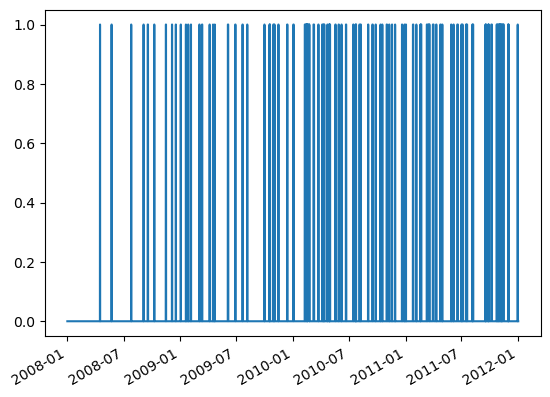

In [186]:
yt.plot()

<AxesSubplot: >

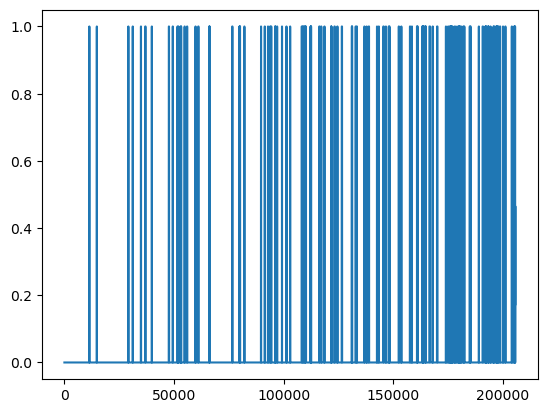

In [134]:
pd.DataFrame(y_pred)[1].plot()

<AxesSubplot: >

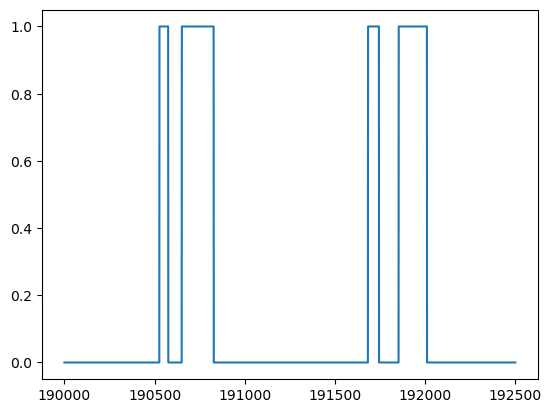

In [192]:
yt2 = yt.copy()
yt2 = yt2.reset_index(drop=True)
yt2.iloc[190000:192500].plot()

<AxesSubplot: >

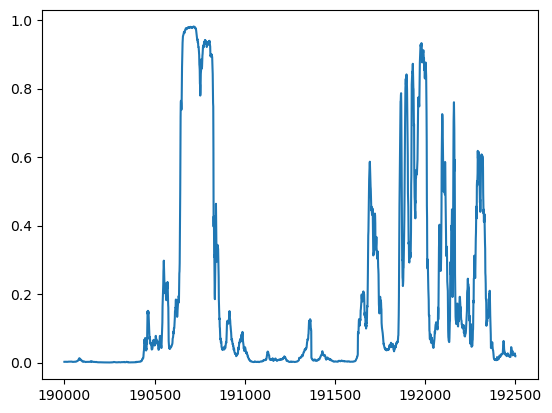

In [193]:
yp = pd.DataFrame(yp)
yp[1].iloc[190000:192500].plot()

In [147]:
classifier.predict(Xt)[range(1,10)]

array([0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

<AxesSubplot: >

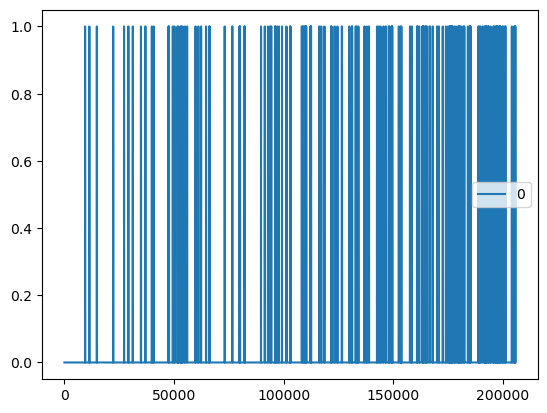

In [142]:
pd.DataFrame(classifier.predict(Xt)).plot()

<AxesSubplot: >

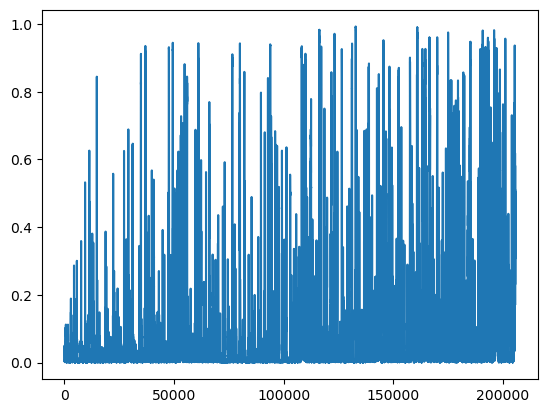

In [144]:
pd.DataFrame(classifier.predict_proba(Xt))[1].plot()